In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [85]:
import torch
from sklearn.metrics import f1_score,classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv("/home/ubuntu/uzair/NLP/text_classification_on_custom_dataset/AirlineTweets.csv")

In [24]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [25]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [26]:
df = df[["text","airline_sentiment"]]

<Axes: >

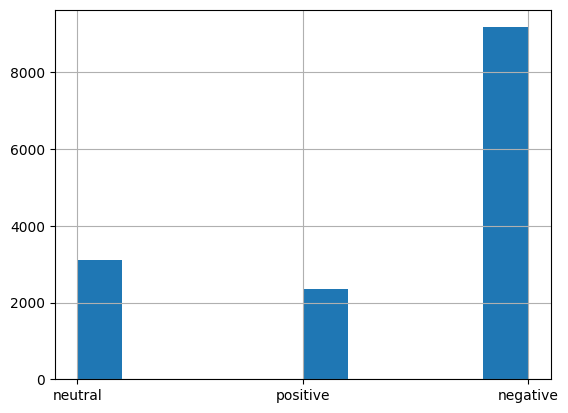

In [27]:
df['airline_sentiment'].hist()

In [28]:
target_map = {"neutral": 2, "positive": 1,"negative": 2}

In [29]:
df['target'] = df['airline_sentiment'].map(target_map)

In [30]:
df.head()

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,2
4,@VirginAmerica and it's a really big bad thing...,negative,2


In [31]:
df2 = df[["text","target"]]

In [32]:
df2.head()

,text,target
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [33]:
df2= df.rename(columns={"target":"label",'text':'sentence'})

In [34]:
df2.head()

,sentence,airline_sentiment,label
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,2
4,@VirginAmerica and it's a really big bad thing...,negative,2


In [47]:
df2=df2.drop(columns='airline_sentiment',axis=1)

In [48]:
df2.to_csv("data.csv",index=False)

In [49]:
from datasets import load_dataset

In [50]:
raw_dataset = load_dataset('csv',data_files='data.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1364.89it/s]
Generating train split: 14640 examples [00:00, 481778.61 examples/s]


In [51]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [52]:
split = raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [53]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [56]:
checkpoint = "distilbert-base-cased"

In [57]:
from transformers import AutoTokenizer

In [58]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [59]:
def tokenize_func(batch):
    return tokenizer(batch['sentence'],truncation=True)

In [60]:
tokenized_datasets = split.map(tokenize_func,batched=True)

Map: 100%|██████████| 4392/4392 [00:00<00:00, 32711.91 examples/s]


In [61]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [63]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels =3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from torchinfo import summary

In [64]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [65]:
training_args = TrainingArguments(
    output_dir = "training_dir",
    evaluation_strategy = 'epoch',
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_eval_batch_size=16,
    per_gpu_eval_batch_size=64
)

In [81]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits,axis=-1)
    accuracy = np.mean(predictions==labels)
    f1 = f1_score(labels,predictions,average='macro')
    return {"accuracy": accuracy, "f1 score":f1}

In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [69]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,0.259000,0.208779,0.923953,0.848453
2,0.179100,0.256195,0.933515,0.866308
3,0.099100,0.307706,0.933515,0.867339


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_de

TrainOutput(global_step=3843, training_loss=0.1901529988614712, metrics={'train_runtime': 122.0068, 'train_samples_per_second': 251.986, 'train_steps_per_second': 31.498, 'total_flos': 359638842460032.0, 'train_loss': 0.1901529988614712, 'epoch': 3.0})

In [70]:
from transformers import pipeline

In [71]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-3843',device=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [72]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [73]:
test_preds = savedmodel(split['test']['sentence'])

In [74]:
test_preds

[{'label': 'LABEL_1', 'score': 0.9906533360481262},
 {'label': 'LABEL_1', 'score': 0.9894772171974182},
 {'label': 'LABEL_1', 'score': 0.9425595998764038},
 {'label': 'LABEL_1', 'score': 0.9720770716667175},
 {'label': 'LABEL_2', 'score': 0.9979698061943054},
 {'label': 'LABEL_2', 'score': 0.9998262524604797},
 {'label': 'LABEL_2', 'score': 0.999297022819519},
 {'label': 'LABEL_2', 'score': 0.9994990825653076},
 {'label': 'LABEL_1', 'score': 0.9857558608055115},
 {'label': 'LABEL_2', 'score': 0.9998409748077393},
 {'label': 'LABEL_2', 'score': 0.9998478889465332},
 {'label': 'LABEL_2', 'score': 0.9998637437820435},
 {'label': 'LABEL_1', 'score': 0.9810787439346313},
 {'label': 'LABEL_2', 'score': 0.9998524188995361},
 {'label': 'LABEL_2', 'score': 0.999043881893158},
 {'label': 'LABEL_2', 'score': 0.9991518259048462},
 {'label': 'LABEL_2', 'score': 0.9994309544563293},
 {'label': 'LABEL_2', 'score': 0.9998016953468323},
 {'label': 'LABEL_2', 'score': 0.9994008541107178},
 {'label': 'LA

In [75]:
def get_label(d):
    return int(d['label'].split('_')[1])

In [76]:
test_preds = [get_label(d) for d in test_preds]

In [86]:
print("accuracy:",accuracy_score(split['test']['label'],test_preds))

accuracy: 0.9335154826958105


In [88]:
print("f1 score:",f1_score(split['test']['label'],test_preds,average='macro'))

f1 score: 0.867339452957715
